# 1. loading datasets

Training has to be done with dropout as data is not always present

In [89]:
import torch
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [90]:

from torch import nn 

# Check PyTorch version
print("PyTorch version:", torch.__version__)

# Check if CUDA is available
print("CUDA available:", torch.cuda.is_available())

# Get current CUDA device index (if available)
if torch.cuda.is_available():
    print("Current CUDA device index:", torch.cuda.current_device())
    print("CUDA device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("No CUDA devices found.")



PyTorch version: 2.4.1+cpu
CUDA available: False
No CUDA devices found.


In [91]:
# Update with the correct path
# file_path = './Data/12_Sep_Readings/combined_data.csv'  
file_path = './Data/15_Nov_Readings/combined_data.csv'
cleaned_df = pd.read_csv(file_path)

In [92]:
cleaned_df

,Tx_0 RSSI,Tx_0 Batt,Tx_0 Time,Tx_1 RSSI,Tx_1 Batt,Tx_1 Time,Tx_2 RSSI,Tx_2 Batt,Tx_2 Time,Tx_3 RSSI,...,Tx_5 Batt,Tx_5 Time,Tx_6 RSSI,Tx_6 Batt,Tx_6 Time,Tx_7 RSSI,Tx_7 Batt,Tx_7 Time,X_Coord,Y_Coord
0,-58.0,4.16,0.0,-65,4.13,0.0,-72.0,4.13,0.0,NaN,...,4.09,0.0,-81.0,4.12,0.0,-73.0,4.10,0.0,0,0
1,-59.0,4.11,21.0,-67,4.15,21.0,-72.0,4.11,20.0,-77.0,...,4.07,17.0,-80.0,4.12,15.0,-75.0,NaN,17.0,0,0
2,-59.0,4.14,38.0,-67,4.14,38.0,-73.0,NaN,40.0,-77.0,...,4.08,40.0,-79.0,4.13,38.0,-76.0,4.11,35.0,0,0
3,-60.0,4.16,57.0,-68,4.13,57.0,-73.0,4.12,56.0,-70.0,...,4.07,54.0,-83.0,4.13,50.0,-76.0,NaN,51.0,0,0
4,-60.0,4.16,74.0,-68,4.13,74.0,-73.0,4.11,72.0,-70.0,...,NaN,79.0,-81.0,4.14,78.0,-76.0,NaN,79.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,-74.0,NaN,357.0,-66,NaN,358.0,-67.0,4.07,357.0,-54.0,...,4.00,357.0,-76.0,4.11,352.0,-77.0,4.06,347.0,5,6
1255,-73.0,4.11,373.0,-67,4.10,368.0,-67.0,4.08,368.0,-54.0,...,4.00,376.0,-75.0,4.10,373.0,-77.0,4.07,367.0,5,6
1256,-73.0,4.11,394.0,-67,NaN,394.0,-68.0,NaN,398.0,-54.0,...,4.01,402.0,-75.0,4.11,397.0,-78.0,4.06,392.0,5,6
1257,-73.0,4.02,419.0,-67,4.11,415.0,-68.0,4.08,415.0,-53.0,...,4.01,419.0,-74.0,4.11,415.0,-78.0,4.06,409.0,5,6


In [93]:

batt_columns = [col for col in cleaned_df.columns if 'Batt' in col]
time_columns = [col for col in cleaned_df.columns if 'Time' in col]
columns_to_drop = batt_columns+time_columns
RSSI_columns = cleaned_df.drop(columns=columns_to_drop)


#Train the model without NAN values
# cleaned_df = RSSI_columns.dropna()

#Convert NaN values to -100
cleaned_df = RSSI_columns.fillna(0)




cleaned_df.shape

(1259, 10)

In [94]:
cleaned_df

,Tx_0 RSSI,Tx_1 RSSI,Tx_2 RSSI,Tx_3 RSSI,Tx_4 RSSI,Tx_5 RSSI,Tx_6 RSSI,Tx_7 RSSI,X_Coord,Y_Coord
0,-58.0,-65,-72.0,0.0,-74.0,-75.0,-81.0,-73.0,0,0
1,-59.0,-67,-72.0,-77.0,-72.0,-76.0,-80.0,-75.0,0,0
2,-59.0,-67,-73.0,-77.0,-70.0,-81.0,-79.0,-76.0,0,0
3,-60.0,-68,-73.0,-70.0,-72.0,-81.0,-83.0,-76.0,0,0
4,-60.0,-68,-73.0,-70.0,-71.0,-82.0,-81.0,-76.0,0,0
...,...,...,...,...,...,...,...,...,...,...
1254,-74.0,-66,-67.0,-54.0,-69.0,-66.0,-76.0,-77.0,5,6
1255,-73.0,-67,-67.0,-54.0,-69.0,-66.0,-75.0,-77.0,5,6
1256,-73.0,-67,-68.0,-54.0,-70.0,-65.0,-75.0,-78.0,5,6
1257,-73.0,-67,-68.0,-53.0,-70.0,-66.0,-74.0,-78.0,5,6


In [95]:
from common_utils import preprocess_dataset

X = cleaned_df[['Tx_0 RSSI', 'Tx_1 RSSI', 'Tx_2 RSSI', 'Tx_3 RSSI', 'Tx_4 RSSI', 'Tx_5 RSSI', 'Tx_6 RSSI', 'Tx_7 RSSI']]
Y = cleaned_df[['X_Coord', 'Y_Coord']]

# Perform the train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Display the results
print("X_train:\n", X_train)
print("X_test:\n", X_test)
print("Y_train:\n", Y_train)
print("Y_test:\n", Y_test)

X_train:
       Tx_0 RSSI  Tx_1 RSSI  Tx_2 RSSI  Tx_3 RSSI  Tx_4 RSSI  Tx_5 RSSI  \
243       -65.0        -56      -69.0      -61.0      -68.0      -72.0   
514       -75.0        -68      -75.0      -68.0      -65.0      -58.0   
966       -84.0        -64      -70.0      -73.0      -69.0      -66.0   
199       -71.0        -80      -76.0      -78.0      -70.0      -79.0   
270       -68.0        -62      -60.0      -64.0        0.0      -70.0   
...         ...        ...        ...        ...        ...        ...   
1044      -72.0        -72      -78.0      -64.0      -72.0      -71.0   
1095      -73.0        -67      -70.0      -64.0      -64.0      -63.0   
1130      -75.0        -66      -77.0        0.0      -67.0      -62.0   
860       -70.0        -68      -68.0      -72.0      -75.0      -80.0   
1126      -74.0        -66      -77.0      -85.0      -68.0      -62.0   

      Tx_6 RSSI  Tx_7 RSSI  
243       -78.0      -76.0  
514       -64.0      -68.0  
966       -79.

# 2. NN model

We will try to determine the optimal hyperparameters
1. Loss function
2. model depth and size, restricted to 3 layers

In [96]:
class MLPBuilder(nn.Module):

    def __init__(self, no_features, layers, no_labels = 64):
        super().__init__()
        layer_list = []
        
        # Input layer
        layer_list.append(nn.Linear(no_features, layers[0]))
        layer_list.append(nn.ReLU())
        layer_list.append(nn.Dropout(p=0.2))

        # Hidden layers
        for i in range(len(layers) - 1):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
            layer_list.append(nn.ReLU())
            layer_list.append(nn.Dropout(p=0.2))

        # Output layer, 2 outputs
        layer_list.append(nn.Linear(layers[-1], 2))
 
        # Define the MLP stack as a sequential model
        self.mlp_stack = nn.Sequential(*layer_list)

    def forward(self, x):
        logits = self.mlp_stack(x)
        return logits
    
    def _initialize_weights(self):
        for layer in self.mlp_stack:
            if isinstance(layer, nn.Linear):
                # Use Kaiming initialization for ReLU activations
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

In [97]:
# Convert the train and test sets to NumPy arrays first, then to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # Shuffle is typically False for test data



In [98]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in dataloader:
        optimizer.zero_grad() 
        outputs = model(inputs) 
        loss = loss_fn(outputs, targets)  
        loss.backward()  
        optimizer.step()  
        
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)  
        total += targets.size(0)

        # Ensure targets are of shape (batch_size,) for comparison
        if targets.ndim == 1:  # Ensure targets are 1D
            correct += (predicted == targets).sum().item()
        else:
            # In case targets are one-hot encoded
            correct += (predicted == targets.argmax(dim=1)).sum().item()

    avg_loss = running_loss / len(dataloader)  # Average loss for the epoch
    accuracy = correct / total  # Training accuracy
    return avg_loss, accuracy

def test_loop(dataloader, model, loss_fn):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # No need to compute gradients during testing
        for inputs, targets in dataloader:
            outputs = model(inputs)  # Forward pass
            loss = loss_fn(outputs, targets)  # Compute the loss
            
            running_loss += loss.item()
            total += targets.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability
            
            # Ensure targets are of shape (batch_size,) for comparison
            if targets.ndim == 1:  # Ensure targets are 1D
                correct += (predicted == targets).sum().item()
            else:
                # In case targets are one-hot encoded
                correct += (predicted == targets.argmax(dim=1)).sum().item()

    avg_loss = running_loss / len(dataloader)  # Average loss for the epoch
    accuracy = correct / total  # Testing accuracy
    return avg_loss, accuracy

In [99]:
import itertools

x = [32, 64, 128, 256]

# Generate all combinations for each possible length (1 to 4 elements)
combinations = []
for r in range(1, 4):  # r goes from 1 to 3
    combinations.extend(itertools.product(x, repeat=r))

# Convert to list format and print
combinations = [list(comb) for comb in combinations]
print(combinations)

[[32], [64], [128], [256], [32, 32], [32, 64], [32, 128], [32, 256], [64, 32], [64, 64], [64, 128], [64, 256], [128, 32], [128, 64], [128, 128], [128, 256], [256, 32], [256, 64], [256, 128], [256, 256], [32, 32, 32], [32, 32, 64], [32, 32, 128], [32, 32, 256], [32, 64, 32], [32, 64, 64], [32, 64, 128], [32, 64, 256], [32, 128, 32], [32, 128, 64], [32, 128, 128], [32, 128, 256], [32, 256, 32], [32, 256, 64], [32, 256, 128], [32, 256, 256], [64, 32, 32], [64, 32, 64], [64, 32, 128], [64, 32, 256], [64, 64, 32], [64, 64, 64], [64, 64, 128], [64, 64, 256], [64, 128, 32], [64, 128, 64], [64, 128, 128], [64, 128, 256], [64, 256, 32], [64, 256, 64], [64, 256, 128], [64, 256, 256], [128, 32, 32], [128, 32, 64], [128, 32, 128], [128, 32, 256], [128, 64, 32], [128, 64, 64], [128, 64, 128], [128, 64, 256], [128, 128, 32], [128, 128, 64], [128, 128, 128], [128, 128, 256], [128, 256, 32], [128, 256, 64], [128, 256, 128], [128, 256, 256], [256, 32, 32], [256, 32, 64], [256, 32, 128], [256, 32, 256],

In [100]:
def determine_depth_and_width(layer_combinations, epochs):
    results = []  # Store results for all layer configurations
    training_times = []  # List to store training times

    for layers in layer_combinations:
        model = MLPBuilder(no_features=X_train.shape[1], layers=layers)
        criterion = nn.MSELoss()
        l2_weight_decay = 1e-4
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=l2_weight_decay)

        # Training loop
        print(f"{'=' * 50}\n"
            f"Layers: {layers}"
              )

        start_time = time.time()  # Start timing the training process

        for epoch in range(epochs):
            # Train the model
            train_loss, train_correct = train_loop(train_loader, model, criterion, optimizer)
            
            # Test the model
            test_loss, test_correct = test_loop(test_loader, model, criterion)

            # Print average loss for the epoch
            print(f"Epoch: [{epoch + 1:>3}/{epochs:<3}]"
                  f"Train Acc: {train_correct * 100:.2f}%, Train Loss: {train_loss:.6f}  |  "
                  f"Test Acc: {test_correct * 100:.2f}%, Test Loss: {test_loss:.6f}\n")

            # Save results only for the last epoch
            if epoch == epochs - 1:
                results.append({
                    'layers': layers,
                    'train_loss': train_loss,
                    'train_correct': train_correct,
                    'test_loss': test_loss,
                    'test_correct': test_correct,
                })
        print(f"{'=' * 50}\n")

        end_time = time.time()  # End timing the training process
        training_time = end_time - start_time  # Calculate total training time
        training_times.append(training_time)  # Append the training time for this configuration

    return results, training_times


    


In [101]:
# epochs = 10
# results, training_times = determine_depth_and_width(combinations, epochs)

Layers: [32]
Epoch: [  1/10 ]Train Acc: 48.36%, Train Loss: 61.219517  |  Test Acc: 45.63%, Test Loss: 9.702909

Epoch: [  2/10 ]Train Acc: 48.76%, Train Loss: 24.025747  |  Test Acc: 51.19%, Test Loss: 7.674819

Epoch: [  3/10 ]Train Acc: 49.95%, Train Loss: 19.126818  |  Test Acc: 49.21%, Test Loss: 6.860457

Epoch: [  4/10 ]Train Acc: 48.66%, Train Loss: 14.661479  |  Test Acc: 48.41%, Test Loss: 5.974591

Epoch: [  5/10 ]Train Acc: 49.75%, Train Loss: 12.148862  |  Test Acc: 51.19%, Test Loss: 5.701418

Epoch: [  6/10 ]Train Acc: 51.14%, Train Loss: 10.663563  |  Test Acc: 50.00%, Test Loss: 5.425954

Epoch: [  7/10 ]Train Acc: 49.95%, Train Loss: 8.981837  |  Test Acc: 55.56%, Test Loss: 5.215970

Epoch: [  8/10 ]Train Acc: 52.83%, Train Loss: 8.028164  |  Test Acc: 62.30%, Test Loss: 4.951481

Epoch: [  9/10 ]Train Acc: 51.84%, Train Loss: 7.512939  |  Test Acc: 62.70%, Test Loss: 4.727877

Epoch: [ 10/10 ]Train Acc: 58.69%, Train Loss: 6.652663  |  Test Acc: 67.06%, Test Loss: 4

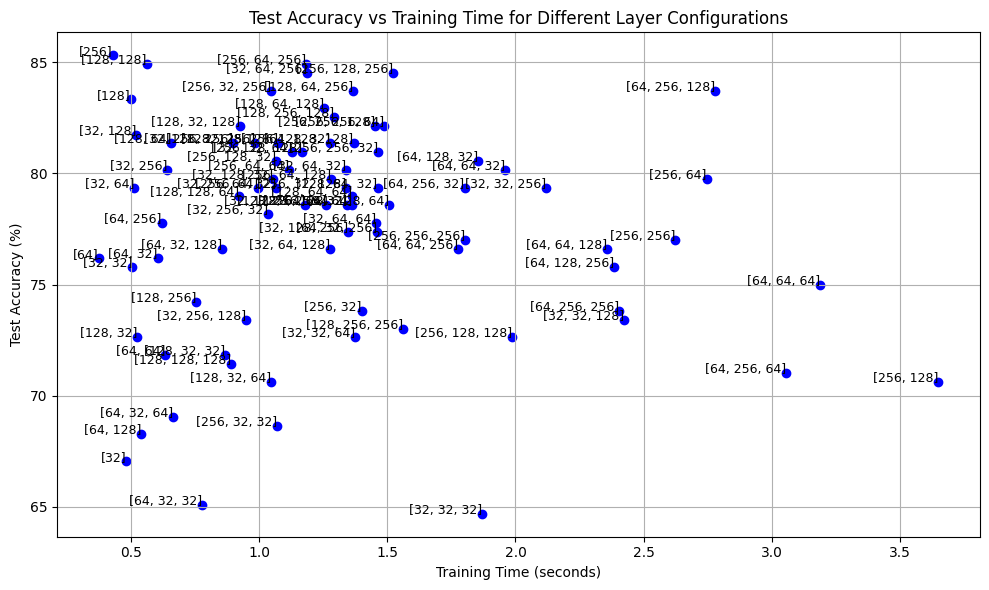

In [102]:
test_accuracies = [result['test_correct'] * 100 for result in results]  # List of test accuracies (in percentage)
layer_configs = [str(result['layers']) for result in results]  # Layer configurations as strings

# Create a scatter plot for Test Accuracy vs. Training Time
plt.figure(figsize=(10, 6))
for i, layer_size in enumerate(layer_configs):
    plt.scatter(training_times[i], test_accuracies[i], color='b')  # Plot point
    plt.text(training_times[i], test_accuracies[i], layer_size, fontsize=9, ha='right')  # Add text label for each point

# Adding labels and title
plt.xlabel('Training Time (seconds)')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy vs Training Time for Different Layer Configurations')

plt.grid(True)
plt.tight_layout()
plt.show()

### The Best Model is seen to be [256,128,32] with the highest accuracy

## Evaluation of Model

In [106]:
model = MLPBuilder(no_features=X_train.shape[1], layers=[256,64,256])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_modelepochs = 500
tr_loss, tr_correct = [], []
te_loss, te_correct = [], []

for epoch in range(best_modelepochs):
    # Train the model
    train_loss, train_correct = train_loop(train_loader, model, criterion, optimizer)
    
    # Test the model
    test_loss, test_correct = test_loop(test_loader, model, criterion)
    
    print(f"Epoch: [{epoch + 1:>3}/{best_modelepochs:<3}]"
            f"Train Acc: {train_correct * 100:.2f}%, Train Loss: {train_loss:.6f}  |  "
            f"Test Acc: {test_correct * 100:.2f}%, Test Loss: {test_loss:.6f}\n")

    tr_loss.append(train_loss)
    tr_correct.append(train_correct)
    te_loss.append(test_loss)
    te_correct.append(test_correct)


torch.save(model.state_dict(), 'models/NN_model.pth')
print("Model saved successfully.")



Epoch: [  1/500]Train Acc: 53.92%, Train Loss: 8.395613  |  Test Acc: 65.87%, Test Loss: 4.885924

Epoch: [  2/500]Train Acc: 53.13%, Train Loss: 5.792006  |  Test Acc: 63.49%, Test Loss: 5.104897

Epoch: [  3/500]Train Acc: 56.31%, Train Loss: 5.457432  |  Test Acc: 64.68%, Test Loss: 5.239685

Epoch: [  4/500]Train Acc: 59.78%, Train Loss: 4.976145  |  Test Acc: 68.65%, Test Loss: 4.856507

Epoch: [  5/500]Train Acc: 63.75%, Train Loss: 4.596933  |  Test Acc: 75.79%, Test Loss: 4.281314

Epoch: [  6/500]Train Acc: 66.24%, Train Loss: 4.299821  |  Test Acc: 78.17%, Test Loss: 4.140821

Epoch: [  7/500]Train Acc: 67.73%, Train Loss: 3.855410  |  Test Acc: 72.22%, Test Loss: 3.862550

Epoch: [  8/500]Train Acc: 70.41%, Train Loss: 3.909519  |  Test Acc: 81.75%, Test Loss: 4.261025

Epoch: [  9/500]Train Acc: 72.59%, Train Loss: 3.710941  |  Test Acc: 68.65%, Test Loss: 2.870760

Epoch: [ 10/500]Train Acc: 73.19%, Train Loss: 3.572183  |  Test Acc: 73.02%, Test Loss: 2.998022

Epoch: [ 1

In [107]:
model.eval()

# Choose a sample input from the test set
inputs = X_test_tensor[:5]  # Select the first 5 samples for demonstration

# Perform the forward pass
with torch.no_grad():  
    outputs = model(inputs)

# Print the model output
print("Model Outputs:\n", outputs)

Model Outputs:
 tensor([[0.5141, 5.5711],
        [3.0574, 3.4109],
        [0.3510, 3.6222],
        [6.3681, 2.8141],
        [6.6988, 1.2918]])


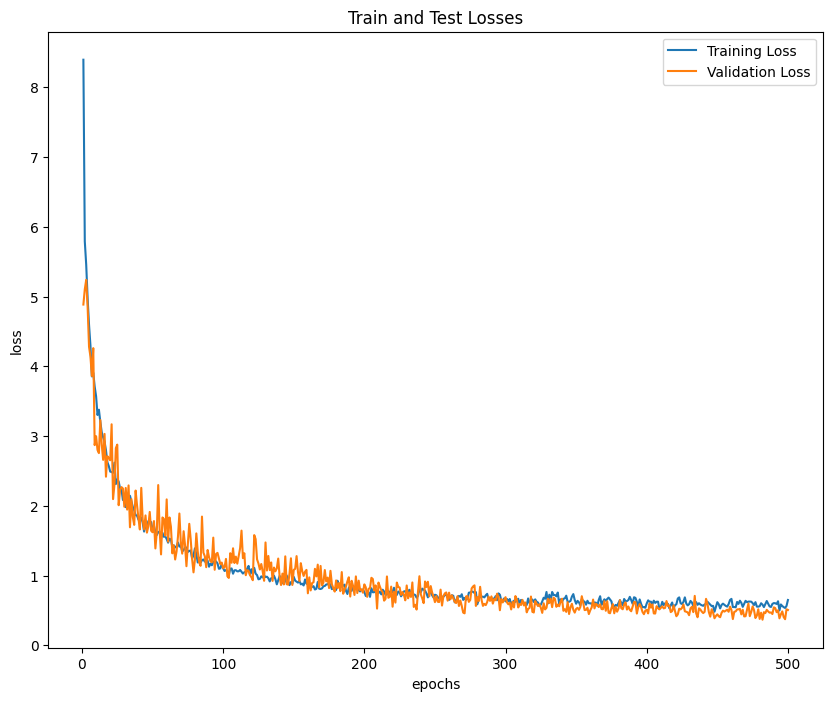

In [108]:

plt.figure(figsize=(10, 8))
plt.plot(range(1,len(tr_loss)+1),tr_loss, label='Training Loss')
plt.plot(range(1,len(te_loss)+1),te_loss,label='Validation Loss')


plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Train and Test Losses')
plt.legend()

plt.show()
